참고문헌

- 파이썬 딥러닝 파이토치 (이경택, 방심수, 안상준 지음), 정보문화사

- https://gaussian37.github.io/dl-pytorch-snippets/

- 2023 KAIA 한국인공지능학회 / Introduction to pytorch (Hyunchul Kim) / 링크 : https://www.youtube.com/watch?v=YX-AgT-Kovg

- PyTorch로 시작하는 딥 러닝 입문 (유원준, 안상준 지음), 링크 : https://wikidocs.net/book/2788

# 1. Linear regression

- Linear regression 모형을 PyTorch를 이용하여 구현해보자.

## 1-1. 데이터

<img src='https://drive.google.com/uc?export=download&id=18aCaLj-GKYSafhlEIg8633zTfeDO_F63' width="" height ="" /><br>

- 어떤 학생이 1시간 공부를 했더니 2점, 다른 학생이 2시간 공부를 했더니 4점, 또 다른 학생이 3시간을 공부했더니 6점을 맞았습니다. 그렇다면, 내가 4시간을 공부한다면 몇 점을 맞을 수 있을까요?

- 훈련 데이터셋 (Training dataset) 과 테스트 데이터 셋 (Test dataset)은?

___코드 1-1. 기본 세팅___

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# 현재 실습하고 있는 파이썬 코드를 재실행해도 다음에도 같은 결과가 나오도록 랜덤 시드(random seed)를 줍니다.
torch.manual_seed(1)

___코드 1-2. 변수 선언___

다음과 같이 training dataset을 설정합니다.

In [ ]:
# training data
x_train = torch.FloatTensor([[1], [2], [3]])
y_train = torch.FloatTensor([[2], [4], [6]])

In [ ]:
# 데이터 확인
print(x_train)
print(x_train.shape)

tensor([[1.],
        [2.],
        [3.]])
torch.Size([3, 1])


___코드 1-3. 모형 설정 및 적합___

- 선형 회귀 모형
  + 선형 회귀란 학습 데이터와 가장 잘 맞는 하나의 직선을 찾는 일입니다 : $$ F(x) = Wx + b $$
  + 선형 회귀의 목표는 가장 잘 맞는 직선을 정의하는 weight $W$와 bias $b$의 값을 찾는 것입니다.

- 모형 적합
  + 비용 함수(cost function) 혹은 손실 함수(loss function)를 설정하고 이를 최적화하는 weight $W$와 bias $b$의 값을 찾아야 합니다.
  + 선형 회귀 모형에서는 cost function (비용함수) 혹은 loss function (손실함수)를 다음과 같이 정의합니다 (최소제곱법 혹은 Maximum likelhiood estimation): $$ cost(W,b) = {1 \over n} \sum_{i=1}^{n}{ (y_i - F(x_i))^2 } $$
  + 선형 회귀 모형의 솔루션은 ananlytic하게 $$ \hat{\boldsymbol{\beta}} = (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y} $$로 손쉽게 계산할 수 있으나, 여기에서는 일반적인 AI 모형의 학습 과정을 공부하기 위하여 최적화 방법론을 적용하여 솔루션을 numerical하게 계산할 것이다.
  + 여기서는 가장 기본적인 형태의 Gradient descent를 활용할 것이다.

___코드 1-3-(1). 가중치와 편향의 초기화___

- 먼저 weight $W$와 bias $b$의 초기값을 정의합니다.
- 다음은 가중치 $W$와 $b$를 0으로 초기화합니다.

In [ ]:
# 가중치 W를 0으로 초기화하고 학습을 통해 값이 변경되는 변수임을 명시함.
W = torch.zeros(1, requires_grad=True)
# 가중치 W를 출력
print(W)

tensor([0.], requires_grad=True)


In [ ]:
# 편향 b를 0으로 초기화하고 학습을 통해 값이 변경되는 변수임을 명시함.
b = torch.zeros(1, requires_grad=True)
print(b)

tensor([0.], requires_grad=True)


- 즉, 현재 직선의 방정식은 $$ y = 0 \times x + 0 $$
- 적절한 $W$와 $b$가 아니므로 training data를 활용하여 적절한 $W$와 $b$를 최적화 방법론을 활용하여 찾아낼 것.

#### (참고) `requires_grad=True`의 의미는?

- 텐서에는 `requires_grad`라는 속성이 있습니다. 이것을 True로 설정하면 자동 미분 (Autograd) 기능이 적용됩니다. 선형 회귀부터 신경망과 같은 복잡한 구조에서 파라미터들이 모두 이 기능이 적용됩니다. `requires_grad = True`가 적용된 텐서에 연산을 하면, 계산 그래프가 생성되며 `backward` 함수를 호출하면 그래프로부터 자동으로 미분이 계산됩니다.

- (example 1)


In [ ]:
import torch
w = torch.tensor(2.0, requires_grad=True)

값이 2인 임의의 스칼라 텐서 `w`를 선언합니다. 이때 `required_grad`를 `True`로 설정합니다. 이는 이 텐서에 대한 기울기를 저장하겠다는 의미입니다. 뒤에서 보겠지만, 이렇게 하면 `w.grad`에 `w`에 대한 미분값이 저장됩니다.  
$ Z= 2\times w^2 + 5$

In [ ]:
y = w**2
z = 2*y + 5

print(y)
print(z)

tensor(4., grad_fn=<PowBackward0>)
tensor(13., grad_fn=<AddBackward0>)


이제 `w`에 대한 수식을 정의합니다.  

In [ ]:
z.backward()
print(w.grad)
#print(y.grad) # : None

tensor(8.)


이제 해당 수식을 `w`에 대해서 미분해야합니다. `.backward()`를 호출하면 해당 수식의 `w`에 대한 기울기를 계산합니다.

- (example 2)


In [ ]:
x = torch.tensor(1.0, requires_grad=True)
z = torch.tensor(2.0, requires_grad=True)
y = x**2 + z**3
y.backward()
print(x.grad, z.grad)
## tensor(2.) tensor(12.)

tensor(2.) tensor(12.)


___코드 1-3-(2). $F(X)$ 계산___

- $y$를 예측하기 위한 $F(X)$를 계산합니다 : $$ F(x) = Wx + b $$

In [ ]:
hypothesis = x_train * W + b
print(hypothesis)

tensor([[0.],
        [0.],
        [0.]], grad_fn=<AddBackward0>)


___코드 1-3-(3). 비용 함수 선언하기___

- cost function (비용함수) 혹은 loss function (손실함수)를 정의합니다. : $$ cost(W,b) = {1 \over n} \sum_{i=1}^{n}{ (y_i - F(x_i))^2 } $$

In [ ]:
cost = torch.mean((hypothesis - y_train) ** 2)
print(cost)

tensor(18.6667, grad_fn=<MeanBackward0>)


- **(주의!!!!)** 이 때 `hypothesis`와 `y_train` 둘 다 `3 x 1` 크기의 텐서이다. 이 둘의 크기를 제대로 맞춰주어야 한다. 만약에 두 오브젝트의 크기를 제대로 맞추지않을 경우 브로드캐스팅에 의해 완전히 잘못된 계산결과가 나올 수 있다.

In [ ]:
# 3 x 1 크기의 2차원 텐서인 y_train대신 길이가 3인 1차원 텐서 y_train_vec을 활용할 경우
y_train_vec = y_train.view(3,)
y_train_vec
hypothesis - y_train_vec
## y_train_vec은 1 x 3으로 취급되고 hypothesis은 3 x 1 크기이므로, broadcasting에 의해 3 x 3 크기로 변환되어 계산된다.

tensor([[-2., -4., -6.],
        [-2., -4., -6.],
        [-2., -4., -6.]], grad_fn=<SubBackward0>)

In [ ]:
# W = 1이고 b=1일 때, 다음과 같이 완전히 다른 cost function의 계산결과가 나옴을 확인할 수 있다.
hypothesis0 = x_train * 1 + 1

cost_right = torch.mean((hypothesis0 - y_train) ** 2) # 올바른 값
cost_wrong = torch.mean((hypothesis0 - y_train_vec) ** 2) # 잘못된 값

print([cost_right, cost_wrong])

[tensor(1.6667), tensor(4.3333)]


___코드 1-3-(4). Gradient descent 구현하기___

<img src='https://drive.google.com/uc?export=download&id=1_qC9Rr0RJmJ3s3AJBYjKE-ub5ulB8GkA' width="" height ="" /><br>

$$ W^{(t+1)} = W^{(t)} - \alpha {\partial cost(W) \over \partial W} $$

- `SGD`함수를 활용하여 Gradient descent를 구현할 수 있습니다.
- lr은 학습률(learning rate, $\alpha$)를 의미합니다.
- 학습 대상인 $W$와 $b$가 SGD의 입력이 됩니다.

In [ ]:
optimizer = optim.SGD([W, b], lr=0.01)

- `optimizer.zero_grad()`를 실행함으로서 미분을 통해 얻은 기울기를 0으로 초기화합니다. 기울기를 초기화해야만 새로운 가중치 편향에 대해서 새로운 기울기를 구할 수 있습니다.
- 이후 `cost.backward()` 함수를 호출하면 가중치 W와 편향 b에 대한 기울기가 계산됩니다.
- 이후 경사 하강법 최적화 함수 `opimizer`의 `.step()` 함수를 호출하여 인수로 들어갔던 W와 b에서 리턴되는 변수들의 기울기에 학습률(learining rate) 0.01을 곱하여 빼줌으로서 업데이트합니다.

In [ ]:
# gradient를 0으로 초기화
optimizer.zero_grad()

# 비용 함수를 미분하여 gradient 계산
cost.backward()

# W와 b를 업데이트
optimizer.step()

### ___전체 코드 구현하기___

- 에포크(Epoch)는 전체 훈련 데이터가 학습에 한 번 사용된 주기를 말합니다.
  + 이번 실습의 경우 2,000번을 수행했습니다.

In [ ]:
# 데이터
x_train = torch.FloatTensor([[1], [2], [3]])
y_train = torch.FloatTensor([[2], [4], [6]])

# 모델 초기화
W = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.01)

# 원하는만큼 gradient descent을 반복
nb_epochs = 1999

# gradient descent
for epoch in range(nb_epochs + 1): # 2000번 반복

    # H(x) 계산
    hypothesis = x_train * W + b

    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, W.item(), b.item(), cost.item()))

Epoch    0/1999 W: 0.187, b: 0.080 Cost: 18.666666
Epoch  100/1999 W: 1.746, b: 0.578 Cost: 0.048171
Epoch  200/1999 W: 1.800, b: 0.454 Cost: 0.029767
Epoch  300/1999 W: 1.843, b: 0.357 Cost: 0.018394
Epoch  400/1999 W: 1.876, b: 0.281 Cost: 0.011366
Epoch  500/1999 W: 1.903, b: 0.221 Cost: 0.007024
Epoch  600/1999 W: 1.924, b: 0.174 Cost: 0.004340
Epoch  700/1999 W: 1.940, b: 0.136 Cost: 0.002682
Epoch  800/1999 W: 1.953, b: 0.107 Cost: 0.001657
Epoch  900/1999 W: 1.963, b: 0.084 Cost: 0.001024
Epoch 1000/1999 W: 1.971, b: 0.066 Cost: 0.000633
Epoch 1100/1999 W: 1.977, b: 0.052 Cost: 0.000391
Epoch 1200/1999 W: 1.982, b: 0.041 Cost: 0.000242
Epoch 1300/1999 W: 1.986, b: 0.032 Cost: 0.000149
Epoch 1400/1999 W: 1.989, b: 0.025 Cost: 0.000092
Epoch 1500/1999 W: 1.991, b: 0.020 Cost: 0.000057
Epoch 1600/1999 W: 1.993, b: 0.016 Cost: 0.000035
Epoch 1700/1999 W: 1.995, b: 0.012 Cost: 0.000022
Epoch 1800/1999 W: 1.996, b: 0.010 Cost: 0.000013
Epoch 1900/1999 W: 1.997, b: 0.008 Cost: 0.000008

- 최종 훈련 결과를 보면 최적의 기울기
$W$는 2에 가깝고, $b$는 0에 가까운 것을 볼 수 있습니다.

In [ ]:
# test data
W.item() * 4 + b.item() # requires_grad 외에 값만 알고 싶을땐 .item()

7.995454080402851

- 선형회귀 모형의 analytic한 솔루션과 비교를 하면 다음과 같다 : $$ \hat{\boldsymbol{\beta}} = (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y} $$

In [ ]:
# import numpy
import numpy as np


In [ ]:
# prepare data
y_train_np   = y_train.numpy()
x_train_np   = x_train.numpy()
intercept_np = np.ones(shape=(3,1)) # 3x1 1로 이루어진 열벡터 생성
X0_np        = np.concatenate((intercept_np, x_train_np), axis=1)
X0_np

array([[1., 1.],
       [1., 2.],
       [1., 3.]])

In [ ]:
# solution
beta_hat = np.linalg.inv(np.matmul(X0_np.transpose(), X0_np)) @ X0_np.transpose() @ y_train_np
beta_hat

array([[-3.55271368e-15],
       [ 2.00000000e+00]])

- 앞서 구했던 Gradient descent를 통해 구한 값과 거의 동일함을 알 수 있다.

In [ ]:
[b.item(), W.item()] # 위의 값과 동일한 것을 확인가능

[0.005984552204608917, 1.9973673820495605]

___전체 코드 구현하기 (그림 추가)___

Epoch    0/1999 W: 0.187, b: 0.080 Cost: 18.666666


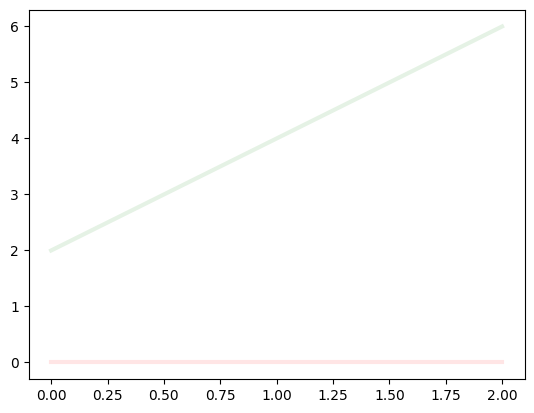

Epoch  100/1999 W: 1.746, b: 0.578 Cost: 0.048171


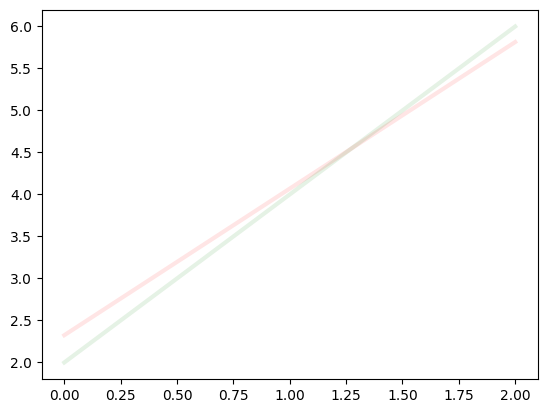

Epoch  200/1999 W: 1.800, b: 0.454 Cost: 0.029767


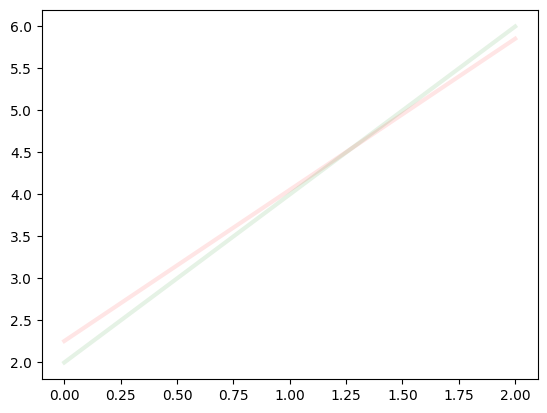

Epoch  300/1999 W: 1.843, b: 0.357 Cost: 0.018394


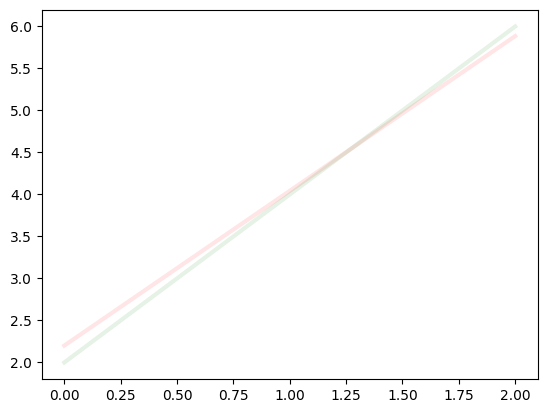

Epoch  400/1999 W: 1.876, b: 0.281 Cost: 0.011366


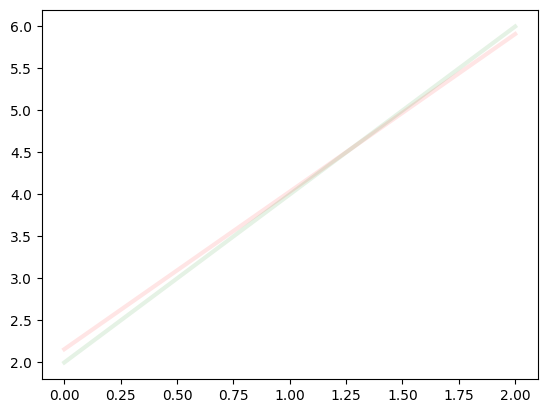

Epoch  500/1999 W: 1.903, b: 0.221 Cost: 0.007024


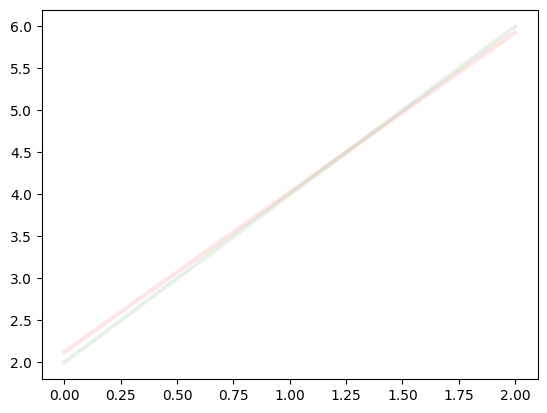

Epoch  600/1999 W: 1.924, b: 0.174 Cost: 0.004340


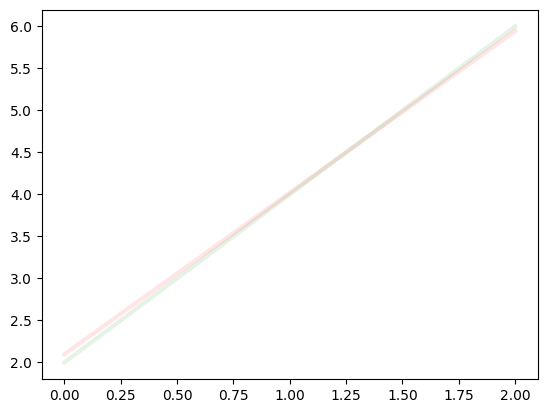

Epoch  700/1999 W: 1.940, b: 0.136 Cost: 0.002682


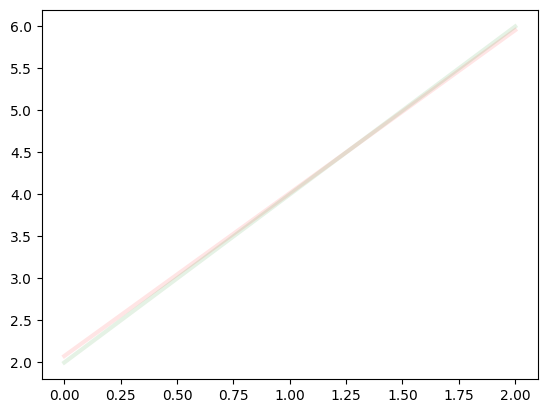

Epoch  800/1999 W: 1.953, b: 0.107 Cost: 0.001657


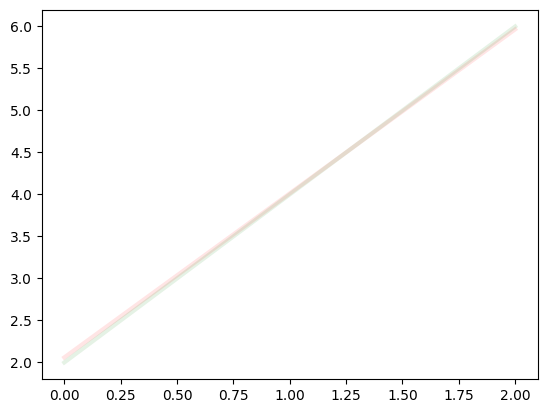

Epoch  900/1999 W: 1.963, b: 0.084 Cost: 0.001024


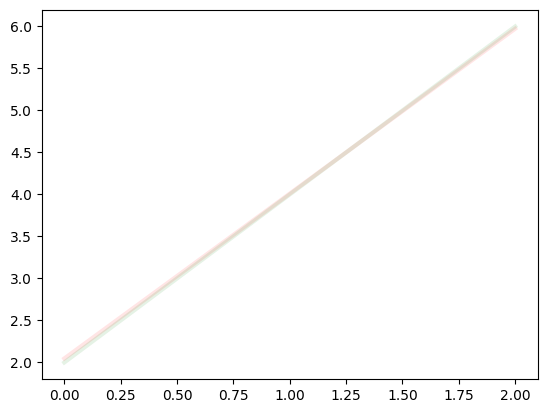

Epoch 1000/1999 W: 1.971, b: 0.066 Cost: 0.000633


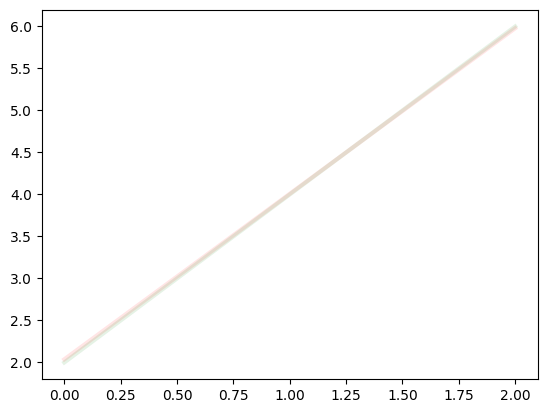

Epoch 1100/1999 W: 1.977, b: 0.052 Cost: 0.000391


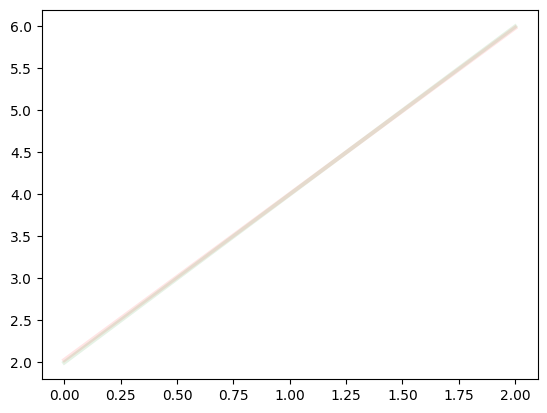

Epoch 1200/1999 W: 1.982, b: 0.041 Cost: 0.000242


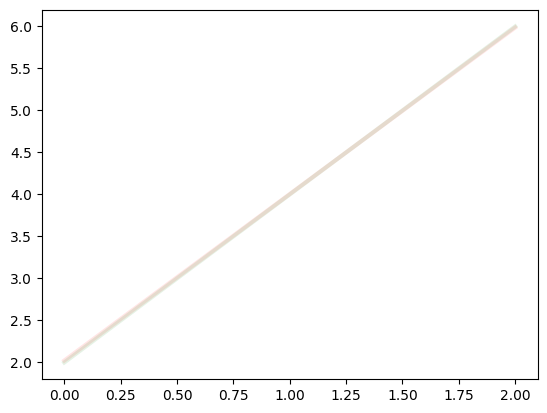

Epoch 1300/1999 W: 1.986, b: 0.032 Cost: 0.000149


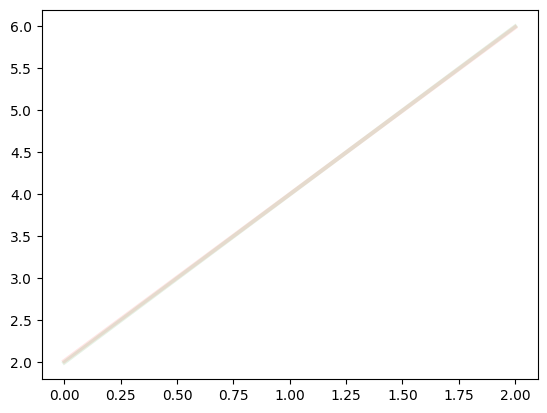

Epoch 1400/1999 W: 1.989, b: 0.025 Cost: 0.000092


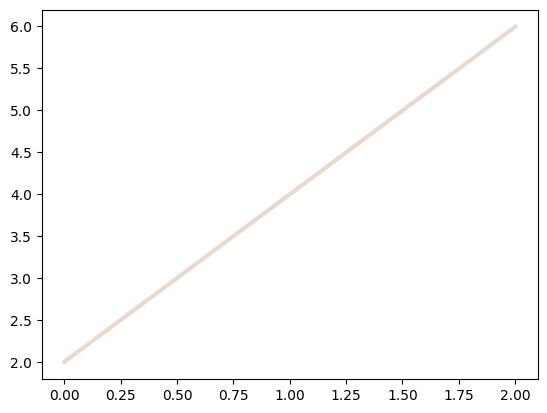

Epoch 1500/1999 W: 1.991, b: 0.020 Cost: 0.000057


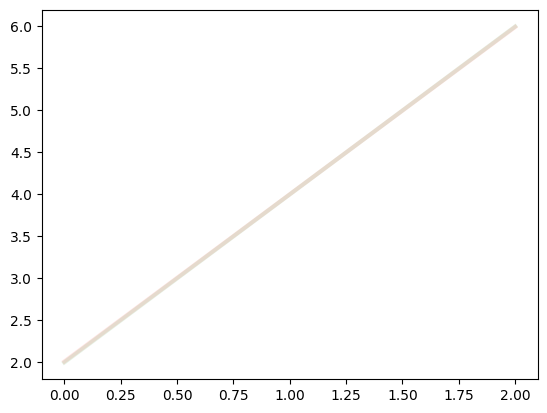

Epoch 1600/1999 W: 1.993, b: 0.016 Cost: 0.000035


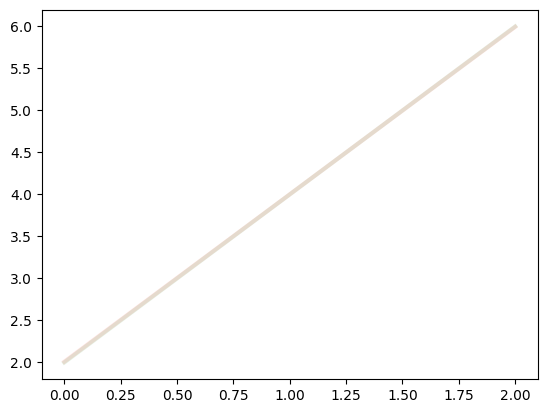

Epoch 1700/1999 W: 1.995, b: 0.012 Cost: 0.000022


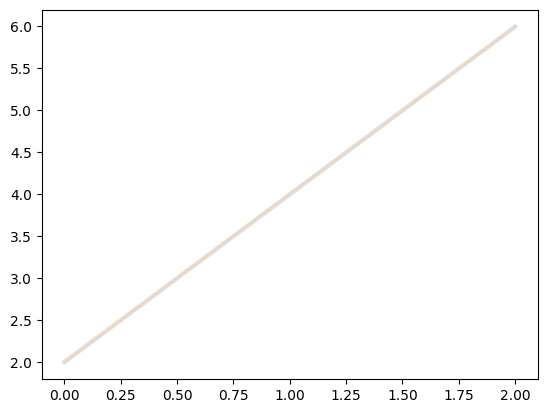

Epoch 1800/1999 W: 1.996, b: 0.010 Cost: 0.000013


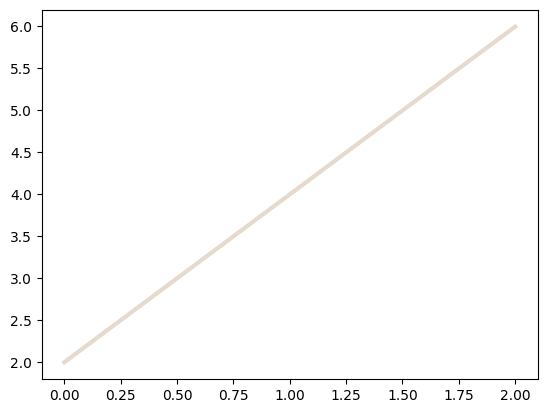

Epoch 1900/1999 W: 1.997, b: 0.008 Cost: 0.000008


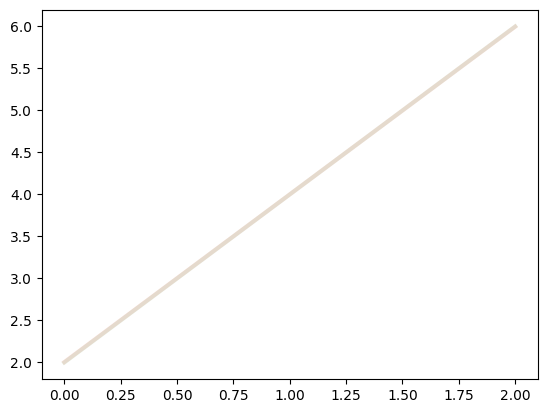

In [ ]:
import matplotlib.pyplot as plt

# 데이터
x_train = torch.FloatTensor([[1], [2], [3]])
y_train = torch.FloatTensor([[2], [4], [6]])

# 모델 초기화
W = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.01)

# 원하는만큼 경사 하강법을 반복
nb_epochs = 1999

# cost 저장
cost_vals = torch.zeros(nb_epochs+1)

# gradient descent
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = x_train * W + b

    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # cost 저장
    cost_vals[epoch] = cost.item()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, W.item(), b.item(), cost.item()))

        # 그림 추가
        pred_y = hypothesis.detach() # 기존 tensor에서 gradient가 전파가 안되는 텐서 생성
        line1 = plt.plot(pred_y, c="red", alpha=0.1, lw=3) # Wx+b를 출력
        line1 = plt.plot(y_train, c="green", alpha=0.1, lw=3) # y를 출력
        plt.show()

- 최적화문제를 풀면서 iteration이 지나감에 따라 cost function의 변화는 다음과 같다

tensor([1.8667e+01, 1.4771e+01, 1.1692e+01,  ..., 5.2128e-06, 5.1872e-06,
        5.1626e-06])


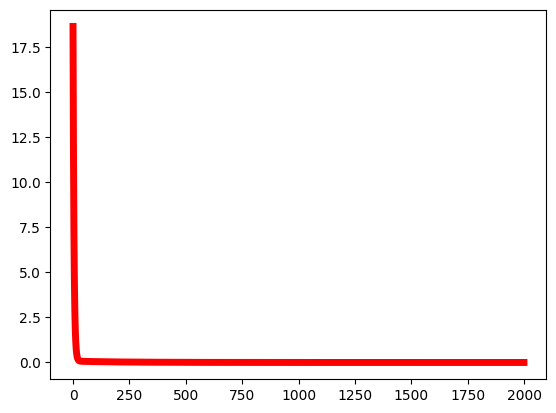

In [ ]:
# iteration이 지남에 따라 cost function의 변화
print(cost_vals)

line1 = plt.plot(cost_vals, c="red", lw=5)
plt.show()

### (참고) `optimizer.zero_grad()`가 필요한 이유

- 파이토치는 미분을 통해 얻은 기울기를 이전에 계산된 기울기 값에 누적시키는 특징이 있습니다.

In [ ]:
w = torch.tensor(2.0, requires_grad=True)

nb_epochs = 20
for epoch in range(nb_epochs + 1):

  z = 2*w

  z.backward()
  print('수식을 w로 미분한 값 : {}'.format(w.grad)) # dz/dw = 2

수식을 w로 미분한 값 : 2.0
수식을 w로 미분한 값 : 4.0
수식을 w로 미분한 값 : 6.0
수식을 w로 미분한 값 : 8.0
수식을 w로 미분한 값 : 10.0
수식을 w로 미분한 값 : 12.0
수식을 w로 미분한 값 : 14.0
수식을 w로 미분한 값 : 16.0
수식을 w로 미분한 값 : 18.0
수식을 w로 미분한 값 : 20.0
수식을 w로 미분한 값 : 22.0
수식을 w로 미분한 값 : 24.0
수식을 w로 미분한 값 : 26.0
수식을 w로 미분한 값 : 28.0
수식을 w로 미분한 값 : 30.0
수식을 w로 미분한 값 : 32.0
수식을 w로 미분한 값 : 34.0
수식을 w로 미분한 값 : 36.0
수식을 w로 미분한 값 : 38.0
수식을 w로 미분한 값 : 40.0
수식을 w로 미분한 값 : 42.0


- 계속해서 미분값인 2가 누적되는 것을 볼 수 있습니다.
- 그렇기 때문에 `optimizer.zero_grad()`를 통해 미분값을 계속 0으로 초기화시켜줘야 합니다.

#### >>>> *(실습) 다중 선형 회귀(Multiple Linear regression)*

이번에는 input $x=(x_1,\dots,x_p)$가 다차원인 상황에서의 다중 선형 회귀 모형을 Gradient descent 기법을 활용하여 구현해보려고 한다.

In [ ]:
torch.manual_seed(1)

# train data 생성
n = 100
x1_train = torch.randn(n)
x2_train = torch.randn(n)
x3_train = torch.randn(n)
x4_train = torch.randn(n)
y_train = x1_train + 2 * x2_train + (-1) * x3_train + (1.5) * x4_train + 0.5 * torch.randn(n)
# y = b0 + b1 x1 + b2 x2 + b3 x3 + b4 x4 + e

위에서 생성한 4차원의 input $x_1, x_2, x_3, x_4$와 output $y$에 대해서 다중 선형 회귀(Multivariable Linear regression)을 구현해 보아라. 실제 참값과 추정한 parameter의 값을 비교하라.

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------
# Learning with SGD .... (문제점 확인하기!)
# ------------------------------------------------------------------------------------------------------------------------------------------------------
w1 = torch.zeros(1, requires_grad=True)
w2 = torch.zeros(1, requires_grad=True)
w3 = torch.zeros(1, requires_grad=True)
w4 = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([w1, w2, w3, w4, b], lr=0.001)

nb_epochs = 10000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = x1_train * w1 + x2_train * w2 + x3_train * w3 + x4_train * w4 + b

    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # Gradient descent
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} w1: {:.2f} w2: {:.2f} w3: {:.2f} w4: {:.2f} b: {:.2f} Cost: {:.3f}'.format(
            epoch, nb_epochs, w1.item(), w2.item(), w3.item(), w4.item(), b.item(), cost.item()
        ))

Epoch    0/9999 w1: -0.000, w2: 0.001, w3: 0.001, w4: 0.000, b: -0.008, Cost: 8.937092
Epoch  100/9999 w1: -0.004, w2: 0.007, w3: 0.008, w4: 0.006, b: -0.340, Cost: 8.785744
Epoch  200/9999 w1: -0.001, w2: 0.002, w3: 0.002, w4: 0.002, b: -0.385, Cost: 8.782888
Epoch  300/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.392, Cost: 8.782822
Epoch  400/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782821
Epoch  500/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782820
Epoch  600/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782821
Epoch  700/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782821
Epoch  800/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782821
Epoch  900/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782820
Epoch 1000/9999 w1: -0.000, w2: 0.000, w3: 0.000, w4: 0.000, b: -0.393, Cost: 8.782820
Epoch 1100/9999 w1: -0.000, w2: 0.000, w3: 

이렇게 추정한 parameter와 실제 참값을 비교해보자(얘도 할줄 알아야함!)

In [ ]:
# 참 값
True_parm   = [0, 1, 2, -1, 1.5]

# Gradient descent를 기반으로 추정한 parameter
Est_parm_GD = [b.item(), w1.item(), w2.item(), w3.item(), w4.item()]

# LSE를 기반으로 추정한 parameter
x_train      = torch.cat([x1_train.reshape(-1,1),
                          x2_train.reshape(-1,1),
                          x3_train.reshape(-1,1),
                          x4_train.reshape(-1,1)], dim=1)
x0_train     = torch.cat([torch.ones(n,1), x_train], dim=1)
XtX          = x0_train.t().matmul(x0_train)
Est_parm_LSE = torch.linalg.inv(XtX).matmul(x0_train.t()).matmul(y_train)

print("참 값 :",            True_parm)
print("Gradient descent :", np.round(Est_parm_GD, 2))
print("일반적인 LSE :",      np.round(Est_parm_LSE, decimals=2))

참 값 : [0, 1, 2, -1, 1.5]
Gradient descent : [-0.016710160300135612, 0.9631404876708984, 1.8894717693328857, -0.9603855609893799, 1.4882738590240479]
일반적인 LSE : tensor([-0.0167,  0.9632,  1.8895, -0.9604,  1.4883])


그리고 다음의 5개의 test data를 기반으로 예측을 해보면,  (테스트 셋 만드는것도 할줄 알아야함!)

In [ ]:
# test data 생성
n_test = 5

## test data - x
x1_test = torch.randn(n_test)
x2_test = torch.randn(n_test)
x3_test = torch.randn(n_test)
x4_test = torch.randn(n_test)

## test data - y mean
ymean_test = x1_test + 2 * x2_test + (-1) * x3_test + (1.5) * x4_test

## test data - y
y_test     = ymean_test + 0.5 * torch.randn(n_test)

In [ ]:
W = torch.tensor([w1, w2, w3, w4])
x_test = torch.cat([x1_test.reshape(-1,1),
                    x2_test.reshape(-1,1),
                    x3_test.reshape(-1,1),
                    x4_test.reshape(-1,1)], dim=1)
print('Predicted y values : ', x_test.matmul(W) + b.item())
print('True y mean values : ', ymean_test)
print('True y values : ', y_test)

Predicted y values :  tensor([-1.0231,  4.6931, -0.6164,  0.6941, -2.8515])
True y mean values :  tensor([-1.0702,  4.8313, -0.5766,  0.8274, -3.0400])
True y values :  tensor([-2.0383,  4.1843, -0.7846,  0.7159, -2.9318])


## nn.Module을 활용하여 구현하기

- nn.Module을 활용하면 이미 구현되어져 제공되고 있는 함수들을 불러올 수 있으므로 더 쉽게 선형 회귀 모델을 구현할 수 있다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

- 다음은 3차원의 input $x_1, x_2, x_3$와 output $y$의 training dataset을 생성한다.
- 이 데이터에 대해서 다중회귀모형을 적용하기 위하여 `nn.Module`을 활용하고자 한다.

In [ ]:
# seed 설정
torch.manual_seed(1)

# train data 생성
## sample size
n = 30

## true parameter
true_bias   = 1
true_weight = torch.tensor([2,-1,1.0])

## generate data
x_train  = torch.randn(n,3)
y_mean0  = true_bias + x_train.matmul(true_weight)
y_train0 = y_mean0 + 0.5 * torch.randn(n) # 평균 + 노이즈 값으로 y_train 정의
y_train  = y_train0.reshape(-1,1) # n x 1 크기로 변환(열벡터 형태)

- nn.Linear()는 입력의 차원, 출력의 차원을 인수로 받습니다.

In [ ]:
# 모델을 선언 및 초기화. input_dim=3, output_dim=1.
model = nn.Linear(3,1)

- model에는 가중치 W와 편향 b가 저장되어져 있습니다. 이 값은 model.parameters()라는 함수를 사용하여 불러올 수 있는데, 한 번 출력해보겠습니다.
  +  첫번째 값이 W고, 두번째 값이 b에 해당

In [ ]:
print(list(model.parameters())) # 첫번째 것이 weight 3개, 두번째가 bias

[Parameter containing:
tensor([[-0.0667, -0.0198, -0.5449]], requires_grad=True), Parameter containing:
tensor([-0.3716], requires_grad=True)]


- 옵티마이저를 정의합니다. model.parameters()를 사용하여 W와 b를 전달합니다.
학습률(learning rate)은 0.01로 정합니다.

In [ ]:
# optimizer 설정. Gradient descent를 사용하고 learning rate를 의미하는 lr은 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# 전체 훈련 데이터에 대해 경사 하강법을 2,000회 반복
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수
    ## prediction과 y_train의 크기 동일하게 맞추어야함.

    # Gradient descent
    ## gradient를 0으로 초기화
    optimizer.zero_grad()

    ## 비용 함수를 미분하여 gradient 계산
    cost.backward() # backward 연산

    ## W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/2000 Cost: 4.992965
Epoch  100/2000 Cost: 0.918670
Epoch  200/2000 Cost: 0.362706
Epoch  300/2000 Cost: 0.278280
Epoch  400/2000 Cost: 0.265328
Epoch  500/2000 Cost: 0.263338
Epoch  600/2000 Cost: 0.263032
Epoch  700/2000 Cost: 0.262985
Epoch  800/2000 Cost: 0.262978
Epoch  900/2000 Cost: 0.262976
Epoch 1000/2000 Cost: 0.262976
Epoch 1100/2000 Cost: 0.262976
Epoch 1200/2000 Cost: 0.262976
Epoch 1300/2000 Cost: 0.262976
Epoch 1400/2000 Cost: 0.262976
Epoch 1500/2000 Cost: 0.262976
Epoch 1600/2000 Cost: 0.262976
Epoch 1700/2000 Cost: 0.262976
Epoch 1800/2000 Cost: 0.262976
Epoch 1900/2000 Cost: 0.262976
Epoch 2000/2000 Cost: 0.262976


- parameter의 추정치와 실제 값은 다음과 같다

In [ ]:
print("추정치", list(model.parameters()))
print("참값", [true_weight, true_bias])

추정치 [Parameter containing:
tensor([[ 2.0757, -0.9611,  0.9661]], requires_grad=True), Parameter containing:
tensor([0.9549], requires_grad=True)]
참값 [tensor([ 2., -1.,  1.]), 1]


- 예측 :

In [ ]:
# 임의의 입력 [1,2,3]를 선언
new_var =  torch.FloatTensor([[1.0, 2.0, 3.0]])
# 입력한 값 [1,2,3]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) # forward 연산
print("훈련 후 예측값 :", pred_y)
print("true mean :", torch.dot(true_weight, new_var.squeeze()) + true_bias)

훈련 후 예측값 : tensor([[4.0065]], grad_fn=<AddmmBackward0>)
true mean : tensor(4.)


## 클래스로 PyTorch 모델 구현하기

- 파이토치의 대부분의 구현체들은 대부분 모델을 생성할 때 클래스(Class)를 사용하고 있습니다.
- 앞서 배운 선형 회귀를 클래스로 구현해보겠습니다.

### 1. 모델을 클래스로 구현하기

- 앞서 단순 선형 회귀 모델은 다음과 같이 구현했었습니다.

In [ ]:
# 모델을 선언 및 초기화. input_dim=3, output_dim=1.
model = nn.Linear(3,1)

- 이를 클래스로 구현하면 다음과 같습니다.

In [ ]:
class MultivariateLinearRegressionModel(nn.Module): # torch.nn.Module을 상속받는 파이썬 클래스
    def __init__(self):
        super().__init__()            # 생성자 상속
        self.linear = nn.Linear(3, 1) # input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [ ]:
model = MultivariateLinearRegressionModel()

- 클래스(class) 형태의 모델은 `nn.Module` 을 상속받습니다.
- 그리고 `__init__()`에서 모델의 구조와 동작을 정의하는 생성자를 정의합니다.
  + 이는 파이썬에서 객체가 갖는 속성값을 초기화하는 역할로, 객체가 생성될 때 자동으로 호출됩니다.
  + `super()` 함수를 부르면 여기서 만든 클래스는 `nn.Module` 클래스의 속성들을 가지고 초기화 됩니다.
- `foward()` 함수는 모델이 학습데이터를 입력받아서 forward 연산을 진행시키는 함수입니다.
  + 이 `forward()` 함수는 `model` 객체를 데이터와 함께 호출하면 자동으로 실행이됩니다.
  + 예를 들어 `model`이란 이름의 객체를 생성 후, `model(입력 데이터)`와 같은 형식으로 객체를 호출하면 자동으로 forward 연산이 수행됩니다.

### 2. 클래스로 구현하기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# seed 설정
torch.manual_seed(1)

# train data 생성
## sample size
n = 30

## true parameter
true_bias   = 1
true_weight = torch.tensor([2,-1,1.0])

## generate data
x_train  = torch.randn(n,3)
y_mean0  = true_bias + x_train.matmul(true_weight)
y_train0 = y_mean0 + 0.5 * torch.randn(n)
y_train  = y_train0.reshape(-1,1) # n x 1 크기로 변환

In [ ]:
class MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1) # 다중 선형 회귀이므로 input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [ ]:
# 모델을 선언 및 초기화.
model = MultivariateLinearRegressionModel()

# optimizer 설정. Gradinet descent 활용
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
nb_epochs = 10000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # Gradient descent
    ## gradient를 0으로 초기화
    optimizer.zero_grad()

    ## 비용 함수를 미분하여 gradient 계산
    cost.backward()

    ## W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/10000 Cost: 4.992965
Epoch  100/10000 Cost: 0.918670
Epoch  200/10000 Cost: 0.362706
Epoch  300/10000 Cost: 0.278280
Epoch  400/10000 Cost: 0.265328
Epoch  500/10000 Cost: 0.263338
Epoch  600/10000 Cost: 0.263032
Epoch  700/10000 Cost: 0.262985
Epoch  800/10000 Cost: 0.262978
Epoch  900/10000 Cost: 0.262976
Epoch 1000/10000 Cost: 0.262976
Epoch 1100/10000 Cost: 0.262976
Epoch 1200/10000 Cost: 0.262976
Epoch 1300/10000 Cost: 0.262976
Epoch 1400/10000 Cost: 0.262976
Epoch 1500/10000 Cost: 0.262976
Epoch 1600/10000 Cost: 0.262976
Epoch 1700/10000 Cost: 0.262976
Epoch 1800/10000 Cost: 0.262976
Epoch 1900/10000 Cost: 0.262976
Epoch 2000/10000 Cost: 0.262976
Epoch 2100/10000 Cost: 0.262976
Epoch 2200/10000 Cost: 0.262976
Epoch 2300/10000 Cost: 0.262976
Epoch 2400/10000 Cost: 0.262976
Epoch 2500/10000 Cost: 0.262976
Epoch 2600/10000 Cost: 0.262976
Epoch 2700/10000 Cost: 0.262976
Epoch 2800/10000 Cost: 0.262976
Epoch 2900/10000 Cost: 0.262976
Epoch 3000/10000 Cost: 0.262976
Epoch 31

- parameter의 추정치와 실제 값은 다음과 같다

In [ ]:
print("추정치", list(model.parameters()))
print("참값", [true_weight, true_bias])

추정치 [Parameter containing:
tensor([[ 2.0757, -0.9611,  0.9661]], requires_grad=True), Parameter containing:
tensor([0.9549], requires_grad=True)]
참값 [tensor([ 2., -1.,  1.]), 1]


- 예측 :

In [ ]:
# 임의의 입력 [1,2,3]를 선언
new_var =  torch.FloatTensor([[1.0, 2.0, 3.0]])
# 입력한 값 [1,2,3]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) # forward 연산
print("훈련 후 예측값 :", pred_y)
print("true mean :", torch.dot(true_weight, new_var.squeeze()) + true_bias)

훈련 후 예측값 : tensor([[4.0065]], grad_fn=<AddmmBackward0>)
true mean : tensor(4.)


#### >>>> *(실습) 다중 선형 회귀(Multivariable Linear regression)*

이번에는 input $x=(x_1,\dots,x_p)$가 다차원인 상황에서의 다중 선형 회귀 모형을 `nn.Module`을 활용하여 구현해보려고 한다. 밑의 training data를 활용하여 모형을 학습하고 training MSE와 test MSE를 계산하라. $$ \text{Mean Squared Error (MSE)} = {1\over n}\sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} $$

In [ ]:
# training data 생성
torch.manual_seed(1)

n = 100
x1_train = torch.randn(n)
x2_train = torch.randn(n)
x3_train = torch.randn(n)
x4_train = torch.randn(n)
y_train = x1_train + 2 * x2_train + (-1) * x3_train + (1.5) * x4_train + 0.5 * torch.randn(n)

# train data 전처리
x_train = torch.cat([x1_train.reshape(-1,1),
                     x2_train.reshape(-1,1),
                     x3_train.reshape(-1,1),
                     x4_train.reshape(-1,1)], dim=1)
y_train = y_train.reshape(-1,1)

In [ ]:
# test data 생성
torch.manual_seed(10)

m = 30
x1_test = torch.randn(m)
x2_test = torch.randn(m)
x3_test = torch.randn(m)
x4_test = torch.randn(m)
y_test  = x1_test + 2 * x2_test + (-1) * x3_test + (1.5) * x4_test + 0.5 * torch.randn(m)

# test data 전처리
x_test = torch.concat(
    [x1_test.reshape(-1,1),
     x2_test.reshape(-1,1),
     x3_test.reshape(-1,1),
     x4_test.reshape(-1,1)],
    dim = 1)
y_test = y_test.reshape(-1,1)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------
# learning with SGD ...
# ----------------------------------------------------------------------------------------------------------------------------------------
class MultivariateLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,1)

    def forward(self, x):
        return self.linear(x)

model = MultivariateLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

nb_epochs = 10000

for epoch in range(nb_epochs+1):

    prediction = model(x_train)
    cost = F.mse_loss(prediction, y_train)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch%100 ==0:
        print('Epoch {:4d}/{} Cost:{:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/10000 Cost:9.384007
Epoch  100/10000 Cost:0.281142
Epoch  200/10000 Cost:0.176231
Epoch  300/10000 Cost:0.173560
Epoch  400/10000 Cost:0.173461
Epoch  500/10000 Cost:0.173457
Epoch  600/10000 Cost:0.173457
Epoch  700/10000 Cost:0.173457
Epoch  800/10000 Cost:0.173457
Epoch  900/10000 Cost:0.173457
Epoch 1000/10000 Cost:0.173457
Epoch 1100/10000 Cost:0.173457
Epoch 1200/10000 Cost:0.173457
Epoch 1300/10000 Cost:0.173457
Epoch 1400/10000 Cost:0.173457
Epoch 1500/10000 Cost:0.173457
Epoch 1600/10000 Cost:0.173457
Epoch 1700/10000 Cost:0.173457
Epoch 1800/10000 Cost:0.173457
Epoch 1900/10000 Cost:0.173457
Epoch 2000/10000 Cost:0.173457
Epoch 2100/10000 Cost:0.173457
Epoch 2200/10000 Cost:0.173457
Epoch 2300/10000 Cost:0.173457
Epoch 2400/10000 Cost:0.173457
Epoch 2500/10000 Cost:0.173457
Epoch 2600/10000 Cost:0.173457
Epoch 2700/10000 Cost:0.173457
Epoch 2800/10000 Cost:0.173457
Epoch 2900/10000 Cost:0.173457
Epoch 3000/10000 Cost:0.173457
Epoch 3100/10000 Cost:0.173457
Epoch 32

- parameter의 추정치와 참값은 다음과 같다

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------
# 참 값
True_parm   = [0, 1, 2, -1, 1.5]

print("추정치", list(model.parameters()))
print("참값", True_parm)
# ----------------------------------------------------------------------------------------------------------------------------------------

추정치 [Parameter containing:
tensor([[ 0.9632,  1.8895, -0.9604,  1.4883]], requires_grad=True), Parameter containing:
tensor([-0.0167], requires_grad=True)]
참값 [0, 1, 2, -1, 1.5]


- training MSE와 test MSE는 다음과 같이 계산할 수 있다.

MSE :0.173457, 0.329037


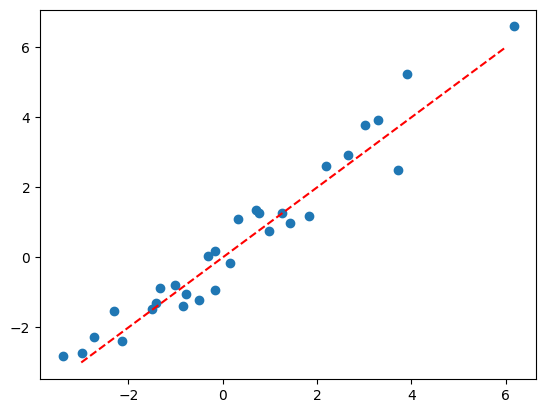

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------
# training MSE vs test MSE
# ----------------------------------------------------------------------------------------------------------------------------------------
mse_trn = F.mse_loss(model(x_train), y_train).detach()
mse_test = F.mse_loss(model(x_test), y_test).detach()

print("MSE :{:.6f}, {:.6f}".format(mse_trn, mse_test))

import matplotlib.pyplot as plt

pred_y = model(x_test).detach()
plt.scatter(pred_y, y_test)
plt.plot([-3,6], [-3,6], color = 'red', linestyle = '--', label = "y = x")

## 미니 배치와 데이터 로드(Mini Batch and Data Load)


### 1. 미니 배치와 배치 크기(Mini Batch and Batch Size)

- 방대한 양의 데이터가 있을 때, 전체 데이터를 더 작은 단위로 나누어서 해당 단위로 학습하는 개념.
  + 이 단위를 미니 배치(Mini Batch)라고 합니다.

<img src='https://drive.google.com/uc?export=download&id=1bfaZLfwmGfj_Bv63Tt9vsap5SLUtzcnd' width="" height ="" /><br>

- 위의 그림은 전체 데이터를 미니 배치 단위로 나누는 것을 보여줍니다.
- 미니 배치 학습을 하게되면 미니 배치만큼만 가져가서 미니 배치에 대한 대한 비용(cost)를 계산하고, 경사 하강법을 수행합니다.
- 그리고 다음 미니 배치를 가져가서 경사 하강법을 수행하고 마지막 미니 배치까지 이를 반복합니다.
- 이렇게 전체 데이터에 대한 학습이 1회 끝나면 1 에포크(Epoch)가 끝나게 됩니다.

- 미니 배치 학습에서는 미니 배치의 개수만큼 경사 하강법을 수행해야 전체 데이터가 한 번 전부 사용되어 1 에포크(Epoch)가 됩니다.
- 미니 배치의 개수는 결국 미니 배치의 크기를 몇으로 하느냐에 따라서 달라지는데 미니 배치의 크기를 배치 크기(batch size)라고 합니다.



- 전체 데이터에 대해서 한 번에 경사 하강법을 수행하는 방법을 **Batch Gradient Descent (배치 경사 하강법)**이라고 부릅니다.
- 미니 배치 단위로 경사 하강법을 수행하는 방법을 **Mini Batch Gradient Descent (미니 배치 경사 하강법)**이라고 부릅니다.

- **Batch Gradient Descent (배치 경사 하강법)**을 할 때, 전체 데이터를 사용하므로 가중치 값이 최적값에 수렴하는 과정이 매우 안정적이지만, 계산량이 너무 많이 듭니다.
- **Mini Batch Gradient Descent (미니 배치 경사 하강법)**을 할 때, 전체 데이터의 일부만을 보고 수행하므로 최적값으로 수렴하는 과정에서 값이 조금 헤매기도 하지만 훈련 속도가 빠릅니다.

- 배치 크기는 보통 2의 제곱수를 사용합니다.
  + ex) 2, 4, 8, 16, 32, 64...
  + 그 이유는 CPU와 GPU의 메모리가 2의 배수이므로 배치크기가 2의 제곱수일 경우에 데이터 송수신의 효율을 높일 수 있다고 합니다.

### 2. 이터레이션(Iteration)

<img src='https://drive.google.com/uc?export=download&id=1Qj2eAUdPPXsbQ-pj_ub8Hfst0EFQr1nN' width="" height ="" /><br>

- 위의 그림은 에포크와 배치 크기와 이터레이션의 관계를 보여줍니다.
- 이터레이션은 한 번의 에포크 내에서 이루어지는 매개변수인 가중치 $W$와 $b$의 업데이트 횟수입니다.
- 전체 데이터가 2,000일 때 배치 크기를 200으로 한다면 이터레이션의 수는 총 10개입니다.
- 이는 한 번의 에포크 당 매개변수 업데이트가 10번 이루어짐을 의미합니다.

### 3. 데이터 로드하기(Data Load)


- 파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 데이터셋(Dataset)과 데이터로더(DataLoader)를 제공합니다.
- 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다.
- 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것입니다.
- Dataset을 커스텀하여 만들 수도 있지만 여기서는 텐서를 입력받아 Dataset의 형태로 변환해주는 TensorDataset을 사용해보겠습니다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# TensorDataset과 DataLoader를 임포트합니다.
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

TensorDataset은 기본적으로 텐서를 입력으로 받습니다. 텐서 형태로 데이터를 정의합니다.

In [ ]:
# seed 설정
torch.manual_seed(1)

# train data 생성
## sample size
n = 100

## true parameter
true_bias   = 1
true_weight = torch.tensor([2,-1,1.0]) # 3차원 x를 가진 Multiple LR

## generate data
x_train  = torch.randn(n,3)
y_mean0  = true_bias + x_train.matmul(true_weight)
y_train0 = y_mean0 + 0.5 * torch.randn(n)
y_train  = y_train0.reshape(-1,1) # n x 1 크기로 변환

- 이제 이를 TensorDataset의 입력으로 사용하고 dataset으로 저장합니다.

In [ ]:
dataset = TensorDataset(x_train, y_train)

- 파이토치의 데이터셋을 만들었다면 데이터로더를 사용 가능합니다.
- 데이터로더는 기본적으로 2개의 인자를 입력받는다.
  + 하나는 데이터셋, 미니 배치의 크기입니다.
  + 이때 미니 배치의 크기는 통상적으로 2의 배수를 사용합니다. (ex) 64, 128, 256...)
- 그리고 추가적으로 많이 사용되는 인자로 shuffle이 있습니다. shuffle=True를 선택하면 Epoch마다 데이터셋을 섞어서 데이터가 학습되는 순서를 바꿉니다.
  + 이 옵션을 True를 주는 것을 권장합니다.

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) # epoch 마다 데이터셋을 섞음. epoch이 달라지면 batch_1의 구성이 달라짐.

- 이제 모델과 옵티마이저를 설계합니다.

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1) # 다중 선형 회귀이므로 input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

# 모델을 선언 및 초기화.
model = MyNet()

# optimizer 설정. Gradinet descent 활용
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
nb_epochs = 2000
for epoch in range(nb_epochs + 1):
  for batch_idx, samples in enumerate(dataloader):
    # print(batch_idx)
    # print(samples)
    tmp_x_train, tmp_y_train = samples

    # H(x) 계산
    prediction = model(tmp_x_train)

    # cost 계산
    cost = F.mse_loss(prediction, tmp_y_train)

    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 1801/2000 Batch 1/25 Cost: 0.154857
Epoch 1801/2000 Batch 2/25 Cost: 0.240737
Epoch 1801/2000 Batch 3/25 Cost: 0.129925
Epoch 1801/2000 Batch 4/25 Cost: 0.234809
Epoch 1801/2000 Batch 5/25 Cost: 0.142552
Epoch 1801/2000 Batch 6/25 Cost: 0.027252
Epoch 1801/2000 Batch 7/25 Cost: 0.170399
Epoch 1801/2000 Batch 8/25 Cost: 0.422131
Epoch 1801/2000 Batch 9/25 Cost: 0.049534
Epoch 1801/2000 Batch 10/25 Cost: 0.321886
Epoch 1801/2000 Batch 11/25 Cost: 0.160790
Epoch 1801/2000 Batch 12/25 Cost: 0.203954
Epoch 1801/2000 Batch 13/25 Cost: 0.386950
Epoch 1801/2000 Batch 14/25 Cost: 0.344002
Epoch 1801/2000 Batch 15/25 Cost: 0.317516
Epoch 1801/2000 Batch 16/25 Cost: 0.455060
Epoch 1801/2000 Batch 17/25 Cost: 0.030087
Epoch 1801/2000 Batch 18/25 Cost: 0.064267
Epoch 1801/2000 Batch 19/25 Cost: 0.326490
Epoch 1801/2000 Batch 20/25 Cost: 0.269220
Epoch 1801/2000 Batch 21/25 Cost: 0.414932
Epoch 1801/2000 Batch 22/25 Cost: 0.385175
Epoch 1801/2000 Batch 23/25

In [ ]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 1.9743, -1.0033,  0.9533]], requires_grad=True), Parameter containing:
tensor([0.9808], requires_grad=True)]


#### >>>> *(실습) 다중 선형 회귀(Multivariable Linear regression)*

이번에는 input $x=(x_1,\dots,x_p)$가 다차원인 상황에서의 다중 선형 회귀 모형을 `nn.Module`을 활용하여 **mini batch Gradient Descent**에 기반하여 구현하라.

In [ ]:
# training data 생성
torch.manual_seed(1)

n = 100
x1_train = torch.randn(n)
x2_train = torch.randn(n)
x3_train = torch.randn(n)
x4_train = torch.randn(n)
y_train = x1_train + 2 * x2_train + (-1) * x3_train + (1.5) * x4_train + 0.5 * torch.randn(n)

# test data 생성
torch.manual_seed(10)

m = 30
x1_test = torch.randn(m)
x2_test = torch.randn(m)
x3_test = torch.randn(m)
x4_test = torch.randn(m)
y_test  = x1_test + 2 * x2_test + (-1) * x3_test + (1.5) * x4_test + 0.5 * torch.randn(m)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------
# 데이터 전처리
## training data
X_tr = torch.cat([x1_train.reshape(-1,1),
                  x2_train.reshape(-1,1),
                  x3_train.reshape(-1,1),
                  x4_train.reshape(-1,1)], dim=1)
y_tr = y_train.reshape(-1,1)

## test data
X_te = torch.cat([x1_test.reshape(-1,1),
                  x2_test.reshape(-1,1),
                  x3_test.reshape(-1,1),
                  x4_test.reshape(-1,1)], dim=1)
y_te = y_test.reshape(-1,1)

# 미니배치 활용
dataset    = TensorDataset(X_tr, y_tr)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 클래스 선언
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 1) # 다중 선형 회귀이므로 input_dim=4, output_dim=1.

    def forward(self, x):
        return self.linear(x)

# 모델을 선언 및 초기화.
model = MyNet()

# optimizer 설정. Gradinet descent 활용
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 최적화
nb_epochs = 2000
for epoch in range(nb_epochs + 1):
  for batch_idx, samples in enumerate(dataloader):

    tmp_x_train, tmp_y_train = samples

    # H(x) 계산
    prediction = model(tmp_x_train)

    # cost 계산
    cost = F.mse_loss(prediction, tmp_y_train)

    # minibatch Gradient descent
    ## gradient를 0으로 초기화
    optimizer.zero_grad()

    ## 비용 함수를 미분하여 gradient 계산
    cost.backward()

    ## W와 b를 업데이트
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))
# ----------------------------------------------------------------------------------------------------------------------------------------

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 1801/2000 Batch 1/25 Cost: 0.099713
Epoch 1801/2000 Batch 2/25 Cost: 0.085700
Epoch 1801/2000 Batch 3/25 Cost: 0.169173
Epoch 1801/2000 Batch 4/25 Cost: 0.233822
Epoch 1801/2000 Batch 5/25 Cost: 0.105580
Epoch 1801/2000 Batch 6/25 Cost: 0.130103
Epoch 1801/2000 Batch 7/25 Cost: 0.395540
Epoch 1801/2000 Batch 8/25 Cost: 0.057006
Epoch 1801/2000 Batch 9/25 Cost: 0.198558
Epoch 1801/2000 Batch 10/25 Cost: 0.415170
Epoch 1801/2000 Batch 11/25 Cost: 0.593203
Epoch 1801/2000 Batch 12/25 Cost: 0.079405
Epoch 1801/2000 Batch 13/25 Cost: 0.102322
Epoch 1801/2000 Batch 14/25 Cost: 0.030126
Epoch 1801/2000 Batch 15/25 Cost: 0.084123
Epoch 1801/2000 Batch 16/25 Cost: 0.114473
Epoch 1801/2000 Batch 17/25 Cost: 0.091509
Epoch 1801/2000 Batch 18/25 Cost: 0.633951
Epoch 1801/2000 Batch 19/25 Cost: 0.112909
Epoch 1801/2000 Batch 20/25 Cost: 0.253341
Epoch 1801/2000 Batch 21/25 Cost: 0.148357
Epoch 1801/2000 Batch 22/25 Cost: 0.044670
Epoch 1801/2000 Batch 23/25

추정치 [Parameter containing:
tensor([[ 0.9660,  1.8898, -0.9657,  1.4928]], requires_grad=True), Parameter containing:
tensor([-0.0134], requires_grad=True)]
참값 [0, 1, 2, -1, 1.5]
MSE :  tensor(0.3300)


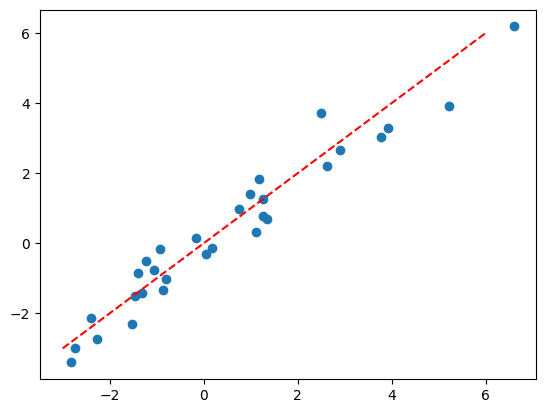

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------
# estimated and true parameters
## true parameters
True_parm   = [0, 1, 2, -1, 1.5]

print("추정치", list(model.parameters()))
print("참값", True_parm)

# test MSE
pred_y_te = model(X_te)
MSE_te = F.mse_loss(pred_y_te, y_te)

# print MSE
print("MSE : ", MSE_te.detach())

# plot
import matplotlib.pyplot as plt
pred_y = pred_y_te.detach() # 기존 tensor에서 gradient가 전파가 안되는 텐서 생성

plt.scatter(y_te, pred_y)   # scatter plot : Y vs \hat{Y}
plt.plot([-3, 6], [-3, 6], color='red', linestyle='--', label="y = x") # line of y=x
plt.show()
# ----------------------------------------------------------------------------------------------------------------------------------------